In [8]:
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from datetime import datetime

# Notebook path
current_directory = os.getcwd()

# Get one behind to call the classes
root_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(root_directory)

from model_class.UD import UD
from model_class.Variety import Variety
from to_get_data.agrobiodiversity_data import *

# Beta's behaviour

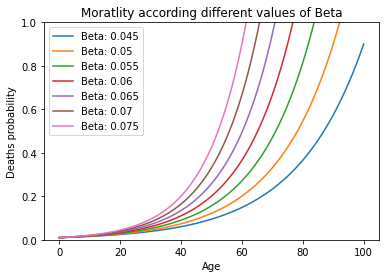

In [2]:
#Betha's behaviour
import numpy as np
import matplotlib.pyplot as plt
import math

# Limits
inicio = 0.045
fin = 0.07
paso = 0.005

# Array of values
ubetas = np.arange(inicio, fin + paso, paso)

def calcular_probabilidad_mortalidad(edad, beta):
    alpha = 0.01
    delta = 0.00
    mortality_rate = alpha * math.exp(beta * (edad)) + delta

    return mortality_rate

#Figure
plt.figure()

for beta in ubetas:
    edades = list(range(101))
    probabilidades = [calcular_probabilidad_mortalidad(edad, beta) for edad in edades]
    # Visz
    plt.plot(edades, probabilidades, label=f'Beta: {round(beta, 4)}')

plt.xlabel('Age')
plt.ylabel('Deaths probability' )
plt.legend()
plt.title('Moratlity according different values of Beta')

# Limit
plt.ylim(0, 1)

plt.show()

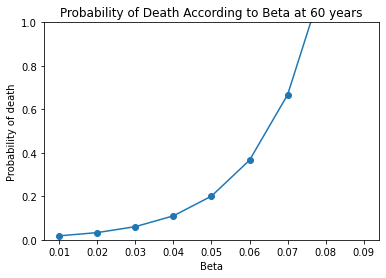

In [3]:
def calcular_probabilidad_mortalidad(edad, beta):
    alpha = 0.01
    delta = 0.00
    mortality_rate = alpha * math.exp(beta * (edad)) + delta

    return mortality_rate

# Beta values
valores_beta = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

edad = 60

beta_probabilities = {}

for beta in valores_beta:
    beta_probabilities[beta] = calcular_probabilidad_mortalidad(edad, beta)

# Change of probability with beta.
plt.plot(valores_beta, list(beta_probabilities.values()), marker='o')
plt.xlabel('Beta')
plt.ylabel('Probability of death')
plt.title('Probability of Death According to Beta at 60 years')
plt.ylim(0, 1)
plt.show()

## Experimento con media de hijos y # de unidades iniciales

### Beta 0.06

In [2]:
#This experiment has the beta fixed in 0.06
prob_morte = 0.06
n = 4
m = 50
malphas = np.linspace(1,n,n) # Average number of children: from 1 to n
mbetas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
mM = np.empty((len(malphas), len(mbetas)), dtype=object)
punto_vista = 2
tiempo = 600
tempo = list(range(0,tiempo,punto_vista))
experiments = 2

# For data of behaviour
datos_1 = np.empty((len(malphas), len(mbetas)), dtype=object)
print(mM.shape)
start = time.time()

for i, media in enumerate(malphas):
    for j, iniciais  in enumerate(mbetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        for experiment in range(1, experiments+1):
            #### Initialization
            ## Comunidades
            UD.uds = {}
            comunidades_disponibles = [i for i in range(1, (int(iniciais) // 10) + 1) for _ in range(10)]
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))
            ## Variedades y repartirlas entre las comunidades
            for id_ud, ud in UD.uds.items():
                for _ in range(5):
                    ud.varieties.append(Variety())
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                uds_copy = dict(UD.uds)
                any_ud_active = False
                for id_ud, ud in uds_copy.items():
                    if ud.activa == True:
                        any_ud_active = True
                        ud.ter_filho()
                        ud.buscar_ud(int(media),0, True)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                if not any_ud_active:
                    # Only 0
                    #print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
#                 if t%100 == 0:
#                     print(f"tamos en tiempo {t} con vivas {viv}")
            # Average Annual Population Growth
            # First 0 avoid errors 
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Get growth rate before the 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                # Growth rate
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        end_config = time.time()
        mM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration}
        datos_1[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of mean {media} and initial UDs {iniciais} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'resultados_parametros_locality'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'filhos_unidadesiniciais_locality.npy')
np.save(heat_std, mM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'filhos_unidadesiniciais_datos_locality.npy')
np.save(behavior, datos_1)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(4, 5)

The total time of the configuration of mean 1.0 and initial UDs 10.0 is  0.023774147033691406
        

The total time of the configuration of mean 1.0 and initial UDs 20.0 is  0.028840303421020508
        

The total time of the configuration of mean 1.0 and initial UDs 30.0 is  0.021053552627563477
        

The total time of the configuration of mean 1.0 and initial UDs 40.0 is  0.020716428756713867
        

The total time of the configuration of mean 1.0 and initial UDs 50.0 is  0.02866506576538086
        

The total time of the configuration of mean 2.0 and initial UDs 10.0 is  0.0156404972076416
        

The total time of the configuration of mean 2.0 and initial UDs 20.0 is  0.031237125396728516
        

The total time of the configuration of mean 2.0 and initial UDs 30.0 is  0.05146169662475586
        

The total time of the configuration of mean 2.0 and initial UDs 40.0 is  0.08039689064025879
        

The total time of the configuration of mean 2.0 and initial U

In [3]:
# Dowload the documents
#As a reference
n = 4
m = 50
malphas = np.linspace(1,n,n) # Average number of children: from 1 to n
mbetas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
#Folders
folder_name = 'resultados_parametros_locality'
heat_std = os.path.join(folder_name, 'filhos_unidadesiniciais_locality.npy')
behavior = os.path.join(folder_name, 'filhos_unidadesiniciais_datos_locality.npy')
## heatmap and mean
mM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
mM_behavior = np.load(behavior, allow_pickle=True)

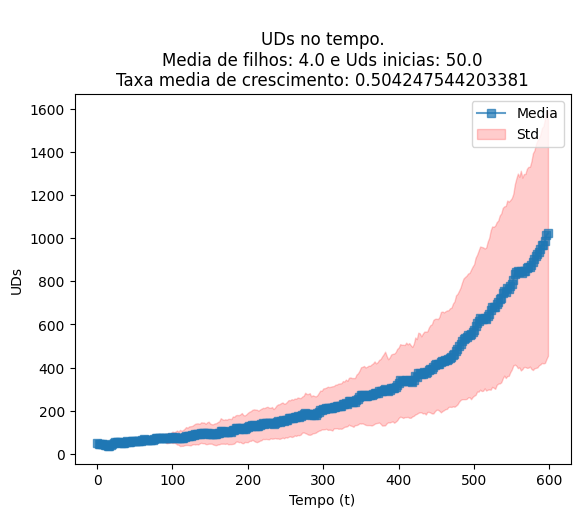

In [7]:
#Graph of experiment with mean and std
x = 4
y = 3

# Main line
plt.plot(mM_behavior[y][x]['tempo'], mM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(mM_behavior[y][x]['tempo'], mM_behavior[y][x]['mean'] - mM_behavior[y][x]['std'],
                 mM_behavior[y][x]['mean'] + mM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Media de filhos: {malphas[y]} e Uds inicias: {mbetas[x]}
Taxa media de crescimento: {mM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

Text(0.5, 0, 'Unidades iniciais')

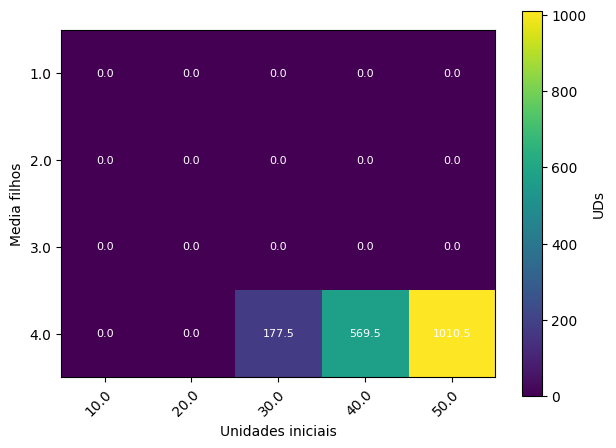

In [5]:
#Heatmap. 
#Get the vales from the document.
alive_values = np.array([[entry['alive'] for entry in row] for row in mM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(mbetas)))
ax.set_yticks(np.arange(len(malphas)))
ax.set_xticklabels(mbetas)
ax.set_yticklabels(malphas)
#Size
for i in range(len(malphas)):
    for j in range(len(mbetas)):
        ax.text(j, i, f'{alive_values[i, j]:.1f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Unidades iniciais")

# Experiment with mean of children and Beta
### Initial UDs: 30

In [33]:
#This experiment has Uds inicias in 30
iniciais = 30
n = 4
ualphas = np.linspace(1,n,n) # Average number of children: from 1 to n
ubetas = np.arange(0.045, 0.07 + 0.005, 0.005) # Beta from 0.045 to 0.075
uM = np.empty((len(ualphas), len(ubetas)), dtype=object)
punto_vista = 2
tiempo = 600
tempo = list(range(0,tiempo,punto_vista))
experiments = 2

start = time.time()
# For data of behaviour
datos_2 = np.empty((len(ualphas), len(ubetas)), dtype=object)
print(uM.shape)

for i, media in enumerate(ualphas):
    for j, prob_morte  in enumerate(ubetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        for experiment in range(1, experiments+1):
            #### Initialization
            ## Comunidades
            UD.uds = {}
            comunidades_disponibles = [i for i in range(1, (int(iniciais) // 10) + 1) for _ in range(10)]
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))
            ## Variedades y repartirlas entre las comunidades
            for id_ud, ud in UD.uds.items():
                for _ in range(5):
                    ud.varieties.append(Variety())
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                uds_copy = dict(UD.uds)
                any_ud_active = False
                for id_ud, ud in uds_copy.items():
                    if ud.activa == True:
                        any_ud_active = True
                        ud.ter_filho()
                        ud.buscar_ud(int(media),0, True)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                if not any_ud_active:
                    # Only 0
                    #print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
            # Average Annual Population Growth
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Only before 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        end_config = time.time()
        uM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration}
        datos_2[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of mean {media} and beta {prob_morte:.3f} is  {end_config - star_configuration}
        """)
# Folders and save
folder_name = 'resultados_parametros_locality'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'filhos_morte_locality.npy')
np.save(heat_std, uM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'filhos_morte_datos_locality.npy')
np.save(behavior, datos_2)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(4, 7)

The total time of the configuration of mean 1.0 and beta 0.045 is  0.025615453720092773
        

The total time of the configuration of mean 1.0 and beta 0.050 is  0.027486562728881836
        

The total time of the configuration of mean 1.0 and beta 0.055 is  0.03576970100402832
        

The total time of the configuration of mean 1.0 and beta 0.060 is  0.026119709014892578
        

The total time of the configuration of mean 1.0 and beta 0.065 is  0.04746103286743164
        

The total time of the configuration of mean 1.0 and beta 0.070 is  0.021331071853637695
        

The total time of the configuration of mean 1.0 and beta 0.075 is  0.013744592666625977
        

The total time of the configuration of mean 2.0 and beta 0.045 is  0.16618943214416504
        

The total time of the configuration of mean 2.0 and beta 0.050 is  0.1076200008392334
        

The total time of the configuration of mean 2.0 and beta 0.055 is  0.12026071548461914
        

The total time of 

In [18]:
# Dowload the documents
#As reference
n = 4
ualphas = np.linspace(1,n,n) # Average number of children: from 1 to n
ubetas = np.arange(0.045, 0.07 + 0.005, 0.005) # Beta from 0.045 to 0.075
#Folders
folder_name = 'resultados_parametros_locality'
heat_std = os.path.join(folder_name, 'filhos_morte_locality.npy')
behavior = os.path.join(folder_name, 'filhos_morte_datos_locality.npy')
## heatmap and mean
uM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
uM_behavior = np.load(behavior, allow_pickle=True)

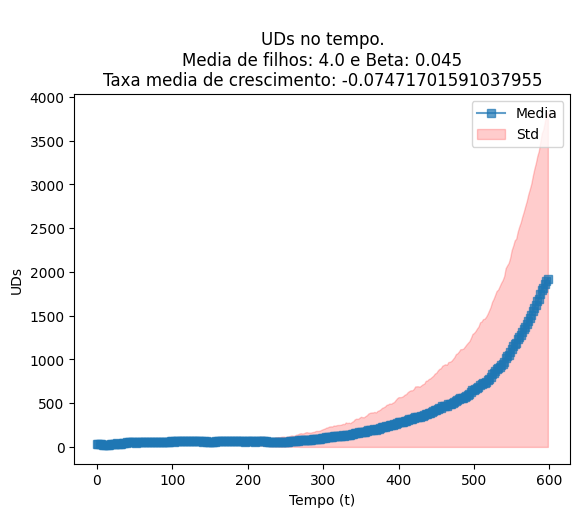

In [11]:
#Graph for each experiment
x = 0
y = 3

# Mean line
plt.plot(uM_behavior[y][x]['tempo'], uM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(uM_behavior[y][x]['tempo'], uM_behavior[y][x]['mean'] - uM_behavior[y][x]['std'],
                 uM_behavior[y][x]['mean'] + uM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Media de filhos: {ualphas[y]} e Beta: {ubetas[x]:.3f}
Taxa media de crescimento: {uM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

Text(0.5, 0, 'Beta')

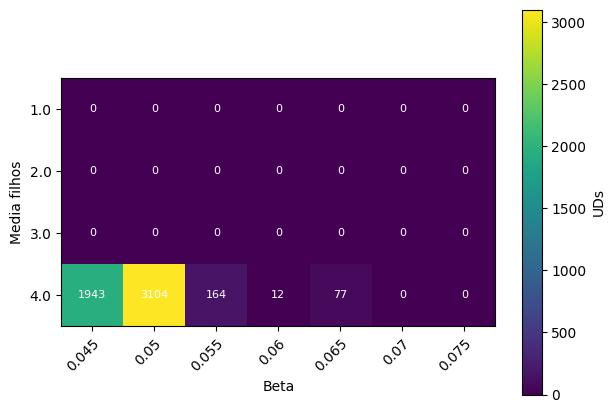

In [16]:
#Heatmap. 
alive_values = np.array([[entry['alive'] for entry in row] for row in uM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(ubetas)))
ax.set_yticks(np.arange(len(ualphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in ubetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in ualphas])
# Size
for i in range(len(ualphas)):
    for j in range(len(ubetas)):
        ax.text(j, i, f'{alive_values[i, j]:.0f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Beta")

## Experiment with initial UDs and Beta

### Mean of children (4)

In [39]:
#This experiment has mean of children: 4
media = 4
n = 50
halphas = np.linspace(10,n,int(n/10)) # Unidades inicias from 10 to 50
hbetas = np.arange(0.05, 0.07 + 0.005, 0.005) # Beta from 0.045 to 0.075
hM = np.empty((len(halphas), len(hbetas)), dtype=object)
punto_vista = 2
tiempo = 600
tempo = list(range(0,tiempo,punto_vista))
experiments = 2

start = time.time()
# For data of behaviour
datos_3 = np.empty((len(halphas), len(hbetas)), dtype=object)
print(uM.shape)

for i, iniciais in enumerate(halphas):
    for j, prob_morte  in enumerate(hbetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        for experiment in range(1, experiments+1):
            #### Initialization
            ## Comunidades
            UD.uds = {}
            comunidades_disponibles = [i for i in range(1, (int(iniciais) // 10) + 1) for _ in range(10)]
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))
            ## Variedades y repartirlas entre las comunidades
            for id_ud, ud in UD.uds.items():
                for _ in range(5):
                    ud.varieties.append(Variety())
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                uds_copy = dict(UD.uds)
                any_ud_active = False
                for id_ud, ud in uds_copy.items():
                    if ud.activa == True:
                        any_ud_active = True
                        ud.ter_filho()
                        ud.buscar_ud(int(media),0, True)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                if not any_ud_active:
                    # Only 0
                    #print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
            # Average Annual Population Growth
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Only before 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        end_config = time.time()
        hM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration}
        datos_3[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of Initial UDs {iniciais} and beta {prob_morte:.3f} is: {end_config - star_configuration}
        """)
# Folders and save
folder_name = 'resultados_parametros_locality'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'morte_unidadesiniciais_locality.npy')
np.save(heat_std, hM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'morte_unidadesiniciais_datos_locality.npy')
np.save(behavior, datos_3)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(4, 7)

The total time of the configuration of Initial UDs 10.0 and beta 0.050 is: 0.009539365768432617
        

The total time of the configuration of Initial UDs 10.0 and beta 0.055 is: 0.011560440063476562
        

The total time of the configuration of Initial UDs 10.0 and beta 0.060 is: 0.005997896194458008
        

The total time of the configuration of Initial UDs 10.0 and beta 0.065 is: 0.008168935775756836
        

The total time of the configuration of Initial UDs 10.0 and beta 0.070 is: 0.008522748947143555
        

The total time of the configuration of Initial UDs 10.0 and beta 0.075 is: 0.006520748138427734
        

The total time of the configuration of Initial UDs 20.0 and beta 0.050 is: 70.52639317512512
        

The total time of the configuration of Initial UDs 20.0 and beta 0.055 is: 0.08403491973876953
        

The total time of the configuration of Initial UDs 20.0 and beta 0.060 is: 0.06508946418762207
        

The total time of the configuration of Init

KeyboardInterrupt: 

In [ ]:
# Dowload the documents
#As reference
n = 50
halphas = np.linspace(10,n,int(n/10)) # Unidades inicias from 10 to 50
hbetas = np.arange(0.05, 0.07 + 0.005, 0.005) # Beta from 0.045 to 0.075
#Folders
folder_name = 'resultados_parametros_locality'
heat_std = os.path.join(folder_name, 'morte_unidadesiniciais_locality.npy')
behavior = os.path.join(folder_name, 'morte_unidadesiniciais_datos_locality.npy')
## heatmap and mean
hM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
hM_behavior = np.load(behavior, allow_pickle=True)

In [ ]:
x = 1
y = 4

# MEan line
plt.plot(hM_behavior[y][x]['tempo'], hM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(hM_behavior[y][x]['tempo'], hM_behavior[y][x]['mean'] - hM_behavior[y][x]['std'],
                 hM_behavior[y][x]['mean'] + hM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std Area')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Unidades iniciais: {halphas[y]} e Beta: {hbetas[x]:.3f}
Taxa media de crescimento: {hM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

In [ ]:
#Heatmap. 
alive_values = np.array([[entry['alive'] for entry in row] for row in hM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(hbetas)))
ax.set_yticks(np.arange(len(halphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in hbetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in halphas])
for i in range(len(halphas)):
    for j in range(len(hbetas)):
        ax.text(j, i, f'{alive_values[i, j]:.0f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("UDs iniciais")
ax.set_xlabel("Beta")

In [11]:
comunidades_disponibles = [i for i in range(1, 3) for _ in range(3)]
comunidades_disponibles

[1, 1, 1, 2, 2, 2]

In [28]:
n=20
comunidades_disponibles = [i for i in range(1, (int(n/5)+1)) for _ in range(int(n/5))]

In [37]:
#### Initialization
## Comunidades
comunidades_disponibles = [i for i in range(1, (int(iniciais/5)+1)) for _ in range(int(iniciais))]
instancias_ud = []
for id_ud in range(1, int(iniciais) + 1):
    instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))

In [39]:
comunidades_disponibles = [i for i in range(1, (int(iniciais/5)+1)) for _ in range(int(iniciais))]
len(comunidades_disponibles)

20